This exercise is dealing with the Titanic Dataset, which is available on Kaggle: https://www.kaggle.com/c/titanic.

The task is to use machine learning to create a model that predicts which passengers survived the Titanic shipwreck.

We will pre-process the data and apply a number of different classifiers to solve this problem.

We will be importing the necessary libraries for this analysis at the places where we need them.

We will first read both datasets - train and test data:

In [1]:
import pandas as pd

raw_data_train = pd.read_csv("titanic_train.csv")
raw_data_test = pd.read_csv("titanic_test.csv")

We will give each dataset a new column called "Type", which separates them into "train" and "test" data. We can use it to identify the source of each case and thus merge and split the data more easily.

In [2]:
raw_data_train["Type"] = "train"
raw_data_test["Type"] = "test"

We will be combining train and test data as we can clean them more easily together. We will split them later again when it comes to training and testing our models.

In [3]:
raw_data_all = pd.concat([raw_data_train, raw_data_test])

We can get a quick overview over the data with an initial table and Panda's profile report feature.

In [4]:
raw_data_all.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Type
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,train
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,train
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,train
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,train
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,train


In [5]:
import pandas_profiling

raw_data_all.profile_report()

Please refer to https://www.kaggle.com/c/titanic/data for more info about the dataset and the variables contained in it. We will not be explaining them in detail here.

We could see from the "Missing values" tab of the report that we have missing values in the data. We can create a table to show more detailled the counts and percentages of missing values in each variable.

In [6]:
missings = pd.DataFrame()
missings["N"] = raw_data_all.isnull().sum().sort_values(ascending = False)
missings["%"] = round(raw_data_all.isnull().sum().sort_values(ascending = False)/len(raw_data_all)*100,2)
missings

,N,%
Cabin,1014,77.46
Survived,418,31.93
Age,263,20.09
Embarked,2,0.15
Fare,1,0.08
Type,0,0.00
Ticket,0,0.00
Parch,0,0.00
SibSp,0,0.00
Sex,0,0.00


We should deal with the missing values one after another. Let's start with the one that has fewest missing values - "Fare". We can filter for the case of interest.

In [7]:
raw_data_all[raw_data_all["Fare"].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Type
152,1044,NaN,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S,test


We can see that the passenger who is missing a values for "Fare" was male, travelling 3rd class, alone, and embarked from Southampton. How high was most other passengers' fare, who travelled with the same characteristics?

In [8]:
Fares = raw_data_all[
    (raw_data_all["Pclass"] == 3) & 
    (raw_data_all["Sex"] == "male") & 
    (raw_data_all["SibSp"] == 0) & 
    (raw_data_all["Parch"] == 0) &
    (raw_data_all["Embarked"] == "S")]["Fare"].value_counts()
Fares.head(5)

8.0500    53
7.8958    42
7.7750    18
7.2500    15
8.6625    14
Name: Fare, dtype: int64

We can see that passengers with the same characteristics most often paid 8.05 dollars. We can assume that the gentleman in question paid a similar amount. We can assign him 8.05 dollars as well. 

We will save a new version of the dataset after each change we make to keep the possibility open to refer back to any given point in the data processing.

In [9]:
data_v001 = raw_data_all.copy()
data_v001.Fare.fillna(8.0500, inplace=True)

Moving on to the second feature with missing values - "Embarked". Again, we can filter for the cases of interest.

In [10]:
data_v001[data_v001["Embarked"].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Type
61,62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,train
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,train


The passengers who are missing a value for "Embarked" were female, travelling 1st class, alone, and paid a fare of 80 dollars. Where did most other passengers embark from, who showed these characteristics?

In [11]:
destination = data_v001[
    (data_v001["Pclass"] == 1) & 
    (data_v001["Sex"] == "female") & 
    (data_v001["SibSp"] == 0) & 
    (data_v001["Parch"] == 0) &
    (data_v001["Fare"] == 80)]["Embarked"].value_counts()
destination

Series([], Name: Embarked, dtype: int64)

Our filter returned an empty list, indicating that we are too specific with one or more of our queries. What if the fare was not exactly 80 dollars but somewhere between 75 and 85 dollars? We can adjust for this requirement.

In [12]:
destination = data_v001[
    (data_v001["Pclass"] == 1) & 
    (data_v001["Sex"] == "female") & 
    (data_v001["SibSp"] == 0) & 
    (data_v001["Parch"] == 0) &
    ((data_v001["Fare"] >= 75) & (data_v001["Fare"] <= 85))]["Embarked"].value_counts()
destination

C    4
S    2
Name: Embarked, dtype: int64

The results indicate that their port of embarkation was likely Cherbourg, but we receive only 6 cases. We can loosen our filters yet a bit more. How do the results look if we were only looking at passenger class and fare?

In [13]:
destination = data_v001[
    (data_v001["Pclass"] == 1) & 
    ((data_v001["Fare"] >= 75) & (data_v001["Fare"] <= 85))]["Embarked"].value_counts()
destination

C    25
S    18
Name: Embarked, dtype: int64

We can conclude that most persons travelling first class on a fare of between 75 and 85 dollars embarked from Cherbourg. As a result, we can assign this value to our missing cases.

In [14]:
data_v002 = data_v001.copy()
data_v002.Embarked.fillna("C", inplace=True)

We will tackle the "Cabin" and "Age" features next. We have a lot of missing values in both of them, with around 77.5% of the sample not having data in the "Cabin" variable and 20% not having data in the "Age" variable. 

We can use the MICE (or iterative imputation) technique to impute missing values using machine learning. However, since the missing results are predicted by using the other available variables in the dataset, we first need to transform into a format that can be interpreted by our imputation algorithm.

We can start with the cabin feature itself. From discussions on Kaggle, we can obtain that the first letter of the cabin refers to the deck number of the ship: https://www.kaggle.com/c/titanic/discussion/4693. This signals that the cabin letter probably carries more importance than the number. We could assume, for instance, that fares would vary depending on which deck the cabin was located, with higher fares on the upper and lower fares on the lower decks.

To investigate our claim, we can first extract the first letter of each cabin to make a new variable "Cabin_Type". In this way, we also receive the missing cabin numbers as "n":

In [15]:
data_v003 = data_v002.copy()
data_v003["Cabin_Type"] = data_v003["Cabin"].astype(str).str[0]

In [16]:
data_v003["Cabin_Type"].value_counts()

n    1014
C      94
B      65
D      46
E      41
A      22
F      21
G       5
T       1
Name: Cabin_Type, dtype: int64

Now we can look which numerical values would make sense to give to each cabin, if we were to explain them by using their price. Ordering them numerically after price would help our MICE imputer to interpret the "Cabin" feature. Let's investigate some measures of central tendency for each cabin class from our new variable to determine an order:

In [17]:
import numpy as np
from scipy import stats

cabins = ["A","B","C","D","E","F","G","T"]

faremin = []
for c in cabins:
    fmin = min(data_v003["Fare"][(data_v003["Cabin_Type"] == c)])
    faremin.append(fmin)
    
faremax = []
for c in cabins:
    fmax = max(data_v003["Fare"][(data_v003["Cabin_Type"] == c)])
    faremax.append(fmax)
    
faremean = []
for c in cabins:
    fmean = np.mean(data_v003["Fare"][(data_v003["Cabin_Type"] == c)])
    faremean.append(fmean)
    
faremed = []
for c in cabins:
    fmed = np.median(data_v003["Fare"][(data_v003["Cabin_Type"] == c)])
    faremed.append(fmed)
    
faremode = []
for c in cabins:
    fmod = stats.mode(data_v003["Fare"][(data_v003["Cabin_Type"] == c)])
    faremode.append(fmod)
    
cabin_prices = pd.DataFrame()
cabin_prices["Cabin Type"] = cabins
cabin_prices["Min"] = faremin
cabin_prices["Max"] = faremax
cabin_prices["Mean"] = faremean
cabin_prices["Median"] = faremed
cabin_prices["Mode"] = faremode

cabin_prices.sort_values(by=["Mean"], ascending=False)

,Cabin Type,Min,Max,Mean,Median,Mode
1,B,0.0000,512.3292,122.383078,82.2667,"([262.375], [6])"
2,C,25.7000,263.0000,107.926598,86.2896,"([263.0], [6])"
4,E,8.0500,134.5000,54.564634,53.1000,"([134.5], [5])"
3,D,12.8750,113.2750,53.007339,52.5542,"([52.5542], [4])"
0,A,0.0000,81.8583,41.244314,35.0771,"([81.8583], [3])"
7,T,35.5000,35.5000,35.500000,35.5000,"([35.5], [1])"
5,F,7.2292,39.0000,18.079367,13.0000,"([7.65], [4])"
6,G,10.4625,16.7000,14.205000,16.7000,"([16.7], [3])"


Our assumption holds partly true. However, the data indicates that decks B and C were actually pricier than the uppermost deck A. Maybe deck A lacked some of the luxury of those decks that were more in the center of the ship. Moreover, prices for decks D and E as well as A and T were quite close together. As expected, decks F and G show the lowest fares.

Taking the summarized measures into consideration, we can recode the cabins in the following order, starting from cheapest to most expensive. We will assign the same value to the "T" and "A" cabin, as their prices are very close to each other, the "T" cabin was not indicated to be existent in the explanatory graphic shown on Kaggle, and there is only one person occupying this type of cabin in the data, which is not enough to treat it as a standalone category:

1 - F <br/>
2 - G <br/>
3 - A <br/>
3 - T <br/>
4 - D <br/>
5 - E <br/>
6 - C <br/>
7 - B <br/>

We can now create the numeric cabin column with these values:

In [18]:
data_v004 = data_v003.copy()
data_v004["Cabin_Type_Num"] = data_v004["Cabin_Type"].replace(["n","F","G","A","T","D","E","C","B"],[np.NaN,1,2,3,3,4,5,6,7])
data_v004.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Type,Cabin_Type,Cabin_Type_Num
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,train,n,NaN
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,train,C,6.0
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,train,n,NaN
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,train,C,6.0
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,train,n,NaN


Our data still has a number of string variables that hold valuable information and should be transformed. We might also want to consider merging some of them to combine the information they are holding and make them more interpretable.

Regarding the "Name" column, we can try to extract meaning from it by isolating the title of each person. This can be useful because we can infer whether a title implies a specific political or societal importance, resulting in these people being prioritized in the rescuing efforts.

In [19]:
data_v005 = data_v004.copy()
data_v005["Title"] = [i.split('.')[0].split(',')[1].strip() for i in data_v005["Name"]]

In [20]:
data_v005['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer', 'Dona'], dtype=object)

We can now split this new variable into two groups, indicating those persons with (1) and without (0) a specific political or societal importance:

With specific importance:

Don<br/>
Dona<br/>
Rev<br/>
Dr<br/>
Major<br/>
Lady<br/>
Sir<br/>
Col<br/>
Capt<br/>
the Countess<br/>
Jonkheer</br>

Without specific importance:

Mr<br/>
Mrs<br/>
Miss<br/>
Master<br/>
Mme<br/>
Ms<br/>
Mlle<br/>

In [21]:
data_v006 = data_v005.copy()
data_v006["VIP"] = data_v006["Title"].replace(
    ["Don","Dona","Rev","Dr","Major","Lady","Sir","Col","Capt","the Countess","Jonkheer",
     "Mr","Mrs","Miss","Master","Mme","Ms","Mlle"],[1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0])
data_v006.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Type,Cabin_Type,Cabin_Type_Num,Title,VIP
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,train,n,NaN,Mr,0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,train,C,6.0,Mrs,0
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,train,n,NaN,Miss,0
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,train,C,6.0,Mrs,0
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,train,n,NaN,Mr,0


Now we can transform the "Sex" variable into a numeric (dummy) format with "0" being man and "1" being woman. We can choose this definition as we could expect women to be more likely to have survived the disaster, not least due to the code of conduct "Women and children first", which was common at the time and dictated that the lives of women and children were to be saved first in a life-threatening situation.

In [22]:
data_v007 = data_v006.copy()
data_v007["Gender"] = data_v007["Sex"].replace(
    ["male","female"],[0,1])
data_v007.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Type,Cabin_Type,Cabin_Type_Num,Title,VIP,Gender
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,train,n,NaN,Mr,0,0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,train,C,6.0,Mrs,0,1
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,train,n,NaN,Miss,0,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,train,C,6.0,Mrs,0,1
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,train,n,NaN,Mr,0,0


We will not transform the Ticket variable, which we will soon elaborate on in more detail, and have thus finished the most important string-to-numeric variable transformations.

However, we can combine the "SibSp" and "Parch" variables into one new variable which tells us whether or not a passenger was travelling alone. This fact is probably more important than who exactly a passenger was travelling with. We will create the new variable as dummy with 0 for not being alone and 1 for being alone. We can choose this direction as we could assume that passengers travelling alone did not have to put themselves in additional danger by ensuring the safety of their relatives, thus having a higher chance at survival.

In [23]:
data_v008 = data_v007.copy()
data_v008["Alone"] = data_v008["SibSp"] + data_v008["Parch"]
data_v008["Alone"].value_counts()

0     790
1     235
2     159
3      43
5      25
4      22
6      16
10     11
7       8
Name: Alone, dtype: int64

In [24]:
data_v008["Alone"] = data_v008["Alone"].replace([0,1,2,3,4,5,6,7,10],[1,0,0,0,0,0,0,0,0])
data_v008.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Type,Cabin_Type,Cabin_Type_Num,Title,VIP,Gender,Alone
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,train,n,NaN,Mr,0,0,0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,train,C,6.0,Mrs,0,1,0
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,train,n,NaN,Miss,0,1,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,train,C,6.0,Mrs,0,1,0
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,train,n,NaN,Mr,0,0,1


We have now transformed all useful string variables and are ready to drop their "old" string versions. Moreover, we will drop the variables "PassengerId" and "Ticket" as they do not contain any further information that is useful for our analysis. This is because "PassengerId" is just a unique identification assigned to each passenger and the ticket number is not of high importance considering that we already know the fare and cabin type for each passenger.

In [25]:
data_v009 = data_v008.drop(["PassengerId","Name","Sex","SibSp","Parch","Ticket","Cabin","Cabin_Type","Title"], axis=1)
data_v009.head(5)

,Survived,Pclass,Age,Fare,Embarked,Type,Cabin_Type_Num,VIP,Gender,Alone
0,0.0,3,22.0,7.2500,S,train,NaN,0,0,0
1,1.0,1,38.0,71.2833,C,train,6.0,0,1,0
2,1.0,3,26.0,7.9250,S,train,NaN,0,1,1
3,1.0,1,35.0,53.1000,S,train,6.0,0,1,0
4,0.0,3,35.0,8.0500,S,train,NaN,0,0,1


By using Pandas' get dummies function, we will now create dummies for the "Embarked" variable for each port. This is wiser than coding them into numerical values as we do not want to imply a numeric relationship between the ports. Pandas' get dummies will by default also transform the "Type" variable into a dummy, which is fine for us as we will be able to identify our train data as cases holding value 1 and test cases holding 0. We will drop the first category for each variable to avoid the dummy variable trap, which is explained here: https://www.algosome.com/articles/dummy-variable-trap-regression.html

In [26]:
data_v010 = pd.get_dummies(data_v009, drop_first=True)
data_v010.head(5)

,Survived,Pclass,Age,Fare,Cabin_Type_Num,VIP,Gender,Alone,Embarked_Q,Embarked_S,Type_train
0,0.0,3,22.0,7.2500,NaN,0,0,0,0,1,1
1,1.0,1,38.0,71.2833,6.0,0,1,0,0,0,1
2,1.0,3,26.0,7.9250,NaN,0,1,1,0,1,1
3,1.0,1,35.0,53.1000,6.0,0,1,0,0,1,1
4,0.0,3,35.0,8.0500,NaN,0,0,1,0,1,1


We have now arrived at the point where we can use our iterative imputer to impute the missing values for "Cabin_Type_Num" and "Age". However, before doing so we should exclude both the "Type_train" and the "Survived" variable as they should not be part of the predictions. This is because "Type_train" only includes information about which part of the data originally belongs to the train or test dataset, while the "Survived" variable was intentionally left blank for the test data as our later model is supposed to predict its outcomes based on our train data. We will "park" these two variables for now and merge them on again at a later point.

In [27]:
extra_variables = data_v010[["Survived","Type_train"]]

In [28]:
data_v011 = data_v010.drop(["Survived","Type_train"], axis=1)
data_v011.head(5)

,Pclass,Age,Fare,Cabin_Type_Num,VIP,Gender,Alone,Embarked_Q,Embarked_S
0,3,22.0,7.2500,NaN,0,0,0,0,1
1,1,38.0,71.2833,6.0,0,1,0,0,0
2,3,26.0,7.9250,NaN,0,1,1,0,1
3,1,35.0,53.1000,6.0,0,1,0,0,1
4,3,35.0,8.0500,NaN,0,0,1,0,1


We can now impute the missing values for both age and cabin type using MICE. Please refer to the following links to get a better insight into this technique and its parameters:

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3074241/ as well as
https://kite.com/python/docs/statsmodels.imputation.mice

We will first use MICE to impute "Cabin_Type_Num" with limits 1-7 (as we have 7 cabin types). We will then merge the predicted cabin type onto our main dataset and use that new version to predict "Age". We can choose this direction as we have fewer missing values for age, which means that, in the first step, age can help us more with predicting the cabin type than the other way around.

In [29]:
from fancyimpute import IterativeImputer as MICE

impute_cabin = MICE(estimator=None,
               missing_values=np.nan,
               sample_posterior=True, 
               max_iter=10, 
               tol=0.001, 
               n_nearest_features=None, 
               initial_strategy='median', 
               imputation_order='descending', 
               skip_complete=False, 
               min_value=1, 
               max_value=7, 
               verbose=0, 
               random_state=333, 
               add_indicator=False)

Using TensorFlow backend.


In [30]:
data_v011_impute_cabin = pd.DataFrame(impute_cabin.fit_transform(data_v011))
data_v011_impute_cabin.head(5)

,0,1,2,3,4,5,6,7,8
0,3.0,22.0,7.2500,2.355314,0.0,0.0,0.0,0.0,1.0
1,1.0,38.0,71.2833,6.000000,0.0,1.0,0.0,0.0,0.0
2,3.0,26.0,7.9250,2.549826,0.0,1.0,1.0,0.0,1.0
3,1.0,35.0,53.1000,6.000000,0.0,1.0,0.0,0.0,1.0
4,3.0,35.0,8.0500,2.198248,0.0,0.0,1.0,0.0,1.0


The imputed column (cabin) was column 3, so we can extract and add it (rounded) to our main dataset.

In [31]:
data_v012 = data_v011.copy()
data_v012["Cabin_New"] = round(data_v011_impute_cabin[3])
data_v012.head(5)

,Pclass,Age,Fare,Cabin_Type_Num,VIP,Gender,Alone,Embarked_Q,Embarked_S,Cabin_New
0,3,22.0,7.2500,NaN,0,0,0,0,1,2.0
1,1,38.0,71.2833,6.0,0,1,0,0,0,6.0
2,3,26.0,7.9250,NaN,0,1,1,0,1,3.0
3,1,35.0,53.1000,6.0,0,1,0,0,1,6.0
4,3,35.0,8.0500,NaN,0,0,1,0,1,2.0


We can now drop the old "Cabin_Type_Num" variable and repeat the process to impute "Age". We will set the maximum limit for age to be 80 as this is the highest value we have observed in our data.

In [32]:
data_v013 = data_v012.drop(["Cabin_Type_Num"], axis=1)

In [33]:
imputer_age = MICE(estimator=None,
               missing_values=np.nan,
               sample_posterior=True, 
               max_iter=10, 
               tol=0.001, 
               n_nearest_features=None, 
               initial_strategy='median', 
               imputation_order='descending', 
               skip_complete=False, 
               min_value=None, 
               max_value=80, 
               verbose=0, 
               random_state=333, 
               add_indicator=False)

In [34]:
data_v013_impute_age = pd.DataFrame(imputer_age.fit_transform(data_v013))
data_v013_impute_age.head(5)

,0,1,2,3,4,5,6,7,8
0,3.0,22.0,7.2500,0.0,0.0,0.0,0.0,1.0,2.0
1,1.0,38.0,71.2833,0.0,1.0,0.0,0.0,0.0,6.0
2,3.0,26.0,7.9250,0.0,1.0,1.0,0.0,1.0,3.0
3,1.0,35.0,53.1000,0.0,1.0,0.0,0.0,1.0,6.0
4,3.0,35.0,8.0500,0.0,0.0,1.0,0.0,1.0,2.0


The imputed column was this time colum 1, so we can extract and add it to our dataset.

In [35]:
data_v014 = data_v013.copy()
data_v014["Age_New"] = round(data_v013_impute_age[1])
data_v014.head(5)

,Pclass,Age,Fare,VIP,Gender,Alone,Embarked_Q,Embarked_S,Cabin_New,Age_New
0,3,22.0,7.2500,0,0,0,0,1,2.0,22.0
1,1,38.0,71.2833,0,1,0,0,0,6.0,38.0
2,3,26.0,7.9250,0,1,1,0,1,3.0,26.0
3,1,35.0,53.1000,0,1,0,0,1,6.0,35.0
4,3,35.0,8.0500,0,0,1,0,1,2.0,35.0


We can now drop the old "Age" variable and merge on our previously "parked" variables again.

In [36]:
data_v015 = data_v014.drop(["Age"], axis=1)

data_v015 = data_v015.reset_index(drop=True)

extra_variables = extra_variables.reset_index(drop=True)

data_v016 = data_v015.join(extra_variables)

data_v016.head(5)

,Pclass,Fare,VIP,Gender,Alone,Embarked_Q,Embarked_S,Cabin_New,Age_New,Survived,Type_train
0,3,7.2500,0,0,0,0,1,2.0,22.0,0.0,1
1,1,71.2833,0,1,0,0,0,6.0,38.0,1.0,1
2,3,7.9250,0,1,1,0,1,3.0,26.0,1.0,1
3,1,53.1000,0,1,0,0,1,6.0,35.0,1.0,1
4,3,8.0500,0,0,1,0,1,2.0,35.0,0.0,1


We can now check once more for missing values in order to make sure that values have been imputed for all missing values.

In [37]:
missings_new = pd.DataFrame()
missings_new["N"] = data_v016.isnull().sum().sort_values(ascending = False)
missings_new["%"] = round(data_v016.isnull().sum().sort_values(ascending = False)/len(raw_data_all)*100,2)
missings_new

,N,%
Survived,418,31.93
Type_train,0,0.00
Age_New,0,0.00
Cabin_New,0,0.00
Embarked_S,0,0.00
Embarked_Q,0,0.00
Alone,0,0.00
Gender,0,0.00
VIP,0,0.00
Fare,0,0.00


Indeed, all missing values have been filled except those for the "Survived" variable, which was not supposed to be imputed.

One last transformation we can apply to our dataset is the creation of age groups from our "Age_New" variable, which we can transform into dummies. This step can help us to group underrepresented ages, interpret the effects of belonging to a specific age group instead of a single age, and mitigate to a certain extent the uncertainty of the results of our data imputation for age with MICE.

Useful age groups were suggested by other Kagglers as:

Up to 1 year -> Infant<br/>
Over 1 up to 4 years -> Toddler<br/>
Over 4 up to 13 years -> Child<br/>
Over 13 up to 17 years -> Teenager<br/>
Over 17 up to 34 years -> Young adult<br/>
Over 34 up to 44 years -> Adult<br/>
Over 44 up to 54 years -> Middle aged<br/>
Over 54 up to 64 years -> Senior citizen<br/>
Over 64 years -> Old

We will apply these intervals by defining a function that we apply to the "Age_New" column via mapping:

In [38]:
def age_groups(age):
    
    a = ''
    if age <= 1:
        a = 'infant'
    elif age <= 4: 
        a = 'toddler'
    elif age <= 13:
        a = 'child'
    elif age <= 17:
        a = 'teenager'
    elif age <= 34:
        a = 'young_adult'
    elif age <= 44:
        a = 'adult'
    elif age <= 54:
        a = 'middle_aged'
    elif age <= 64:
        a = 'senior_citizen'
    else:
        a = 'old'
    return a
        
data_v017 = data_v016.copy()
data_v017['age_group'] = data_v017['Age_New'].map(age_groups)
data_v017.head(5)

,Pclass,Fare,VIP,Gender,Alone,Embarked_Q,Embarked_S,Cabin_New,Age_New,Survived,Type_train,age_group
0,3,7.2500,0,0,0,0,1,2.0,22.0,0.0,1,young_adult
1,1,71.2833,0,1,0,0,0,6.0,38.0,1.0,1,adult
2,3,7.9250,0,1,1,0,1,3.0,26.0,1.0,1,young_adult
3,1,53.1000,0,1,0,0,1,6.0,35.0,1.0,1,adult
4,3,8.0500,0,0,1,0,1,2.0,35.0,0.0,1,adult


We can now apply Panda's get dummy function again to receive dummies for each age group. This time, we will remove the reference category ourselves, so we will not drop the first dummy ceated by default.

In [39]:
data_v018 = pd.get_dummies(data_v017)
data_v018.head(5)

,Pclass,Fare,VIP,Gender,Alone,Embarked_Q,Embarked_S,Cabin_New,Age_New,Survived,Type_train,age_group_adult,age_group_child,age_group_infant,age_group_middle_aged,age_group_old,age_group_senior_citizen,age_group_teenager,age_group_toddler,age_group_young_adult
0,3,7.2500,0,0,0,0,1,2.0,22.0,0.0,1,0,0,0,0,0,0,0,0,1
1,1,71.2833,0,1,0,0,0,6.0,38.0,1.0,1,1,0,0,0,0,0,0,0,0
2,3,7.9250,0,1,1,0,1,3.0,26.0,1.0,1,0,0,0,0,0,0,0,0,1
3,1,53.1000,0,1,0,0,1,6.0,35.0,1.0,1,1,0,0,0,0,0,0,0,0
4,3,8.0500,0,0,1,0,1,2.0,35.0,0.0,1,1,0,0,0,0,0,0,0,0


The age dummy we choose to remove (as reference category) is the one for old passengers, as their chance to survive a disaster such as the sinking of the Titanic is probably the lowest among all age groups (again under consideration of the common "women and children first" etiquette). Moreover, we can drop our "old" age variable in the process.

In [40]:
data_v019 = data_v018.drop(["Age_New", "age_group_old"], axis=1)
data_v019.head(5)

,Pclass,Fare,VIP,Gender,Alone,Embarked_Q,Embarked_S,Cabin_New,Survived,Type_train,age_group_adult,age_group_child,age_group_infant,age_group_middle_aged,age_group_senior_citizen,age_group_teenager,age_group_toddler,age_group_young_adult
0,3,7.2500,0,0,0,0,1,2.0,0.0,1,0,0,0,0,0,0,0,1
1,1,71.2833,0,1,0,0,0,6.0,1.0,1,1,0,0,0,0,0,0,0
2,3,7.9250,0,1,1,0,1,3.0,1.0,1,0,0,0,0,0,0,0,1
3,1,53.1000,0,1,0,0,1,6.0,1.0,1,1,0,0,0,0,0,0,0
4,3,8.0500,0,0,1,0,1,2.0,0.0,1,1,0,0,0,0,0,0,0


As a last step before fitting our classifiers, we need to standardize our numeric, non-dummy variables, which we will do this with Sklearn's Standard Scaler.

To apply Standard Scaler to our numeric variables, we first need to split them from our dataset. We define both numeric and dummy variables as follows:

In [41]:
data_v019_numeric = data_v019[["Pclass","Fare","Cabin_New"]]
data_v019_dummy = data_v019.drop(["Pclass","Fare","Cabin_New"], axis=1)

Now we can apply Standard Scaler to our numeric inputs only.

In [42]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(data_v019_numeric)

data_v019_numeric_scaled = pd.DataFrame(scaler.transform(data_v019_numeric))
                                     
data_v019_numeric_scaled = data_v019_numeric_scaled.rename(columns={0: "Pclass", 1: "Fare", 2: "Cabin_New"})

data_v019_numeric_scaled.head(5)

,Pclass,Fare,Cabin_New
0,0.841916,-0.503176,-0.769757
1,-1.546098,0.734809,1.581729
2,0.841916,-0.490126,-0.181885
3,-1.546098,0.383263,1.581729
4,0.841916,-0.487709,-0.769757


We can now add our scaled variables to the main dataset again. 

In [43]:
data_v020 = data_v019_dummy.reset_index(drop=True)

data_v019_numeric_scaled = data_v019_numeric_scaled.reset_index(drop=True)

data_v020 = data_v020.join(data_v019_numeric_scaled)

data_v020.head(5)

,VIP,Gender,Alone,Embarked_Q,Embarked_S,Survived,Type_train,age_group_adult,age_group_child,age_group_infant,age_group_middle_aged,age_group_senior_citizen,age_group_teenager,age_group_toddler,age_group_young_adult,Pclass,Fare,Cabin_New
0,0,0,0,0,1,0.0,1,0,0,0,0,0,0,0,1,0.841916,-0.503176,-0.769757
1,0,1,0,0,0,1.0,1,1,0,0,0,0,0,0,0,-1.546098,0.734809,1.581729
2,0,1,1,0,1,1.0,1,0,0,0,0,0,0,0,1,0.841916,-0.490126,-0.181885
3,0,1,0,0,1,1.0,1,1,0,0,0,0,0,0,0,-1.546098,0.383263,1.581729
4,0,0,1,0,1,0.0,1,1,0,0,0,0,0,0,0,0.841916,-0.487709,-0.769757


To get a better overview, we can reorder the columns of our dataset. Moreover, we can indicate that we have reached the end of our data pre-processing by giving our dataset the ending "v1".

In [44]:
data_v020.columns.values

array(['VIP', 'Gender', 'Alone', 'Embarked_Q', 'Embarked_S', 'Survived',
       'Type_train', 'age_group_adult', 'age_group_child',
       'age_group_infant', 'age_group_middle_aged',
       'age_group_senior_citizen', 'age_group_teenager',
       'age_group_toddler', 'age_group_young_adult', 'Pclass', 'Fare',
       'Cabin_New'], dtype=object)

In [45]:
new_columns = ['Survived', 'Gender', 'VIP', 'Pclass', 'Fare', 'Cabin_New', 'Alone', 'Embarked_Q', 'Embarked_S', 
               'age_group_infant', 'age_group_toddler', 'age_group_child', 'age_group_teenager', 'age_group_young_adult',
               'age_group_adult', 'age_group_middle_aged', 'age_group_senior_citizen', 'Type_train']

In [46]:
data_v1 = data_v020[new_columns]
data_v1.head(5)

,Survived,Gender,VIP,Pclass,Fare,Cabin_New,Alone,Embarked_Q,Embarked_S,age_group_infant,age_group_toddler,age_group_child,age_group_teenager,age_group_young_adult,age_group_adult,age_group_middle_aged,age_group_senior_citizen,Type_train
0,0.0,0,0,0.841916,-0.503176,-0.769757,0,0,1,0,0,0,0,1,0,0,0,1
1,1.0,1,0,-1.546098,0.734809,1.581729,0,0,0,0,0,0,0,0,1,0,0,1
2,1.0,1,0,0.841916,-0.490126,-0.181885,1,0,1,0,0,0,0,1,0,0,0,1
3,1.0,1,0,-1.546098,0.383263,1.581729,0,0,1,0,0,0,0,0,1,0,0,1
4,0.0,0,0,0.841916,-0.487709,-0.769757,1,0,1,0,0,0,0,0,1,0,0,1


To prepare the data for modelling, we will split our dataset back into train and test data. We are dropping both the "Type_train" and the "Survived" variable (for test data only) in the process.

In [47]:
train = (data_v1[data_v1["Type_train"] == 1]).drop(["Type_train"], axis=1)
test = (data_v1[data_v1["Type_train"] == 0]).drop(["Survived","Type_train"], axis=1)

Proceeding towards our first classification via logistic regression, we can now define the inputs and targets of our train data. However, in order to remove any possible effects that the order of cases in the data might have, we will shuffle the dataset beforehand. We can use Panda's sample method to do this. We can verify the shuffling by examining the train data before and after the shuffling.

In [48]:
train.head(5)

,Survived,Gender,VIP,Pclass,Fare,Cabin_New,Alone,Embarked_Q,Embarked_S,age_group_infant,age_group_toddler,age_group_child,age_group_teenager,age_group_young_adult,age_group_adult,age_group_middle_aged,age_group_senior_citizen
0,0.0,0,0,0.841916,-0.503176,-0.769757,0,0,1,0,0,0,0,1,0,0,0
1,1.0,1,0,-1.546098,0.734809,1.581729,0,0,0,0,0,0,0,0,1,0,0
2,1.0,1,0,0.841916,-0.490126,-0.181885,1,0,1,0,0,0,0,1,0,0,0
3,1.0,1,0,-1.546098,0.383263,1.581729,0,0,1,0,0,0,0,0,1,0,0
4,0.0,0,0,0.841916,-0.487709,-0.769757,1,0,1,0,0,0,0,0,1,0,0


In [49]:
train = train.sample(frac=1)

In [50]:
train.head(5)

,Survived,Gender,VIP,Pclass,Fare,Cabin_New,Alone,Embarked_Q,Embarked_S,age_group_infant,age_group_toddler,age_group_child,age_group_teenager,age_group_young_adult,age_group_adult,age_group_middle_aged,age_group_senior_citizen
190,1.0,1,0,-0.352091,-0.392009,-0.181885,1,0,1,0,0,0,0,1,0,0,0
490,0.0,0,0,0.841916,-0.257318,0.405986,0,0,1,0,0,0,0,1,0,0,0
441,0.0,0,0,0.841916,-0.459676,-1.357628,1,0,1,0,0,0,0,1,0,0,0
504,1.0,1,0,-1.546098,1.029000,2.169600,1,0,1,0,0,0,1,0,0,0,0
720,1.0,1,0,-0.352091,-0.005340,-0.181885,0,0,1,0,0,1,0,0,0,0,0


With the train data being shuffled, we can now define inputs and targets.

In [51]:
train_targets = train["Survived"]
train_inputs = train.drop(["Survived"], axis=1)

As our first classifier will be a logistic regression, we should also check our dataset for multicollinearity as its presence would negatively impact our results. We can check for multicollinearity via the use of Variance Inflation Factors (VIFs). VIF values of 10 or higher have been described as indicating a problematic amount of collinearity, which should be corrected, possibly by dropping the respective variable from the model.

In [52]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(train_inputs.values, i) for i in range(train_inputs.shape[1])]
vif["Regressors"] = train_inputs.columns

vif

,VIF,Regressors
0,1.807731,Gender
1,1.103751,VIP
2,2.579621,Pclass
3,1.659348,Fare
4,2.148987,Cabin_New
5,3.167844,Alone
6,1.603361,Embarked_Q
7,5.093350,Embarked_S
8,1.070742,age_group_infant
9,1.239335,age_group_toddler


We can see that the values for all variables are well below 10, so we can proceed with fitting the logistic regression model with statsmodels.

In [53]:
import statsmodels.api as sm

train_reg_const = sm.add_constant(train_inputs)
reg_log = sm.Logit(train_targets,train_reg_const)
results_log = reg_log.fit()

Optimization terminated successfully.
         Current function value: 0.442119
         Iterations 6


Let's look at the summary:

In [54]:
results_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  891
Model:                          Logit   Df Residuals:                      874
Method:                           MLE   Df Model:                           16
Date:                Sun, 14 Jun 2020   Pseudo R-squ.:                  0.3361
Time:                        10:23:45   Log-Likelihood:                -393.93
converged:                       True   LL-Null:                       -593.33
Covariance Type:            nonrobust   LLR p-value:                 6.501e-75
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -2.4036      0.849     -2.831      0.005      -4.067      -0.740
Gender                       2.7070      0.204     13.280      0.000       2.307       3.106
VIP                         -0.2700      0.539     -0.501      0.616      -1.326       0.786
Pclass                      -0.9836      0.143     -6.892      0.000      -1.263      -0.704
Fare                         0.0173      0.115      0.151      0.880      -0.208       0.243
Cabin_New                   -0.0254      0.127     -0.200      0.842      -0.274       0.224
Alone                        0.2314      0.208      1.111      0.267      -0.177       0.640
Embarked_Q                  -0.1373      0.379     -0.362      0.717      -0.881       0.606
Embarked_S                  -0.5444      0.239     -2.275      0.023      -1.013      -0.075
age_group_infant             3.8142      1.058      3.606      0.000       1.741       5.887
age_group_toddler            1.9949      0.960      2.078      0.038       0.114       3.876
age_group_child              1.3198      0.919      1.436      0.151      -0.481       3.121
age_group_teenager           1.5907      0.901      1.765      0.078      -0.176       3.357
age_group_young_adult        1.0904      0.838      1.301      0.193      -0.553       2.734
age_group_adult              0.8527      0.850      1.003      0.316      -0.814       2.519
age_group_middle_aged        0.6519      0.860      0.758      0.449      -1.034       2.338
age_group_senior_citizen     0.2851      0.915      0.312      0.755      -1.508       2.078
============================================================================================
"""

We can see that several variables do not contribute meaningfully to our model. In particular, the variables "VIP", "Fare", "Cabin_New", "Alone", "Embarked_Q" and all of our age groups except infants and toddlers are not significant, indicated by a p-value of >0.05. As a result, we should remove these variables from our model and perform a re-run.

In [55]:
train_inputs_second = train_inputs.drop([
    "VIP", "Fare", "Cabin_New", "Alone", "Embarked_Q", 
    "age_group_child", "age_group_teenager", "age_group_young_adult", 
    "age_group_adult", "age_group_middle_aged", "age_group_senior_citizen"], axis=1)
train_inputs_second.head(5)

,Gender,Pclass,Embarked_S,age_group_infant,age_group_toddler
190,1,-0.352091,1,0,0
490,0,0.841916,1,0,0
441,0,0.841916,1,0,0
504,1,-1.546098,1,0,0
720,1,-0.352091,1,0,0


In [56]:
train_const_second = sm.add_constant(train_inputs_second)
reg_log_second = sm.Logit(train_targets,train_const_second)
results_log_second = reg_log_second.fit()

Optimization terminated successfully.
         Current function value: 0.447842
         Iterations 6


In [57]:
results_log_second.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  891
Model:                          Logit   Df Residuals:                      885
Method:                           MLE   Df Model:                            5
Date:                Sun, 14 Jun 2020   Pseudo R-squ.:                  0.3275
Time:                        10:23:45   Log-Likelihood:                -399.03
converged:                       True   LL-Null:                       -593.33
Covariance Type:            nonrobust   LLR p-value:                 8.488e-82
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -1.3051      0.184     -7.076      0.000      -1.667      -0.944
Gender                2.6843      0.189     14.207      0.000       2.314       3.055
Pclass               -0.8421      0.092     -9.176      0.000      -1.022      -0.662
Embarked_S           -0.5063      0.194     -2.608      0.009      -0.887      -0.126
age_group_infant      2.6362      0.636      4.146      0.000       1.390       3.882
age_group_toddler     0.8415      0.467      1.802      0.072      -0.074       1.757
=====================================================================================
"""

In the second run, the last age group variable for toddlers loses its significance as well. We will remove the variable and run the regression one more time.

In [58]:
train_inputs_third = train_inputs_second.drop(["age_group_toddler"], axis=1)
train_inputs_third.head(5)

,Gender,Pclass,Embarked_S,age_group_infant
190,1,-0.352091,1,0
490,0,0.841916,1,0
441,0,0.841916,1,0
504,1,-1.546098,1,0
720,1,-0.352091,1,0


In [59]:
train_reg_const_third = sm.add_constant(train_inputs_third)
reg_log_third = sm.Logit(train_targets,train_reg_const_third)
results_log_third = reg_log_third.fit()

Optimization terminated successfully.
         Current function value: 0.449648
         Iterations 6


In [60]:
results_log_third.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  891
Model:                          Logit   Df Residuals:                      886
Method:                           MLE   Df Model:                            4
Date:                Sun, 14 Jun 2020   Pseudo R-squ.:                  0.3248
Time:                        10:23:45   Log-Likelihood:                -400.64
converged:                       True   LL-Null:                       -593.33
Covariance Type:            nonrobust   LLR p-value:                 4.004e-82
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -1.2859      0.184     -6.985      0.000      -1.647      -0.925
Gender               2.6900      0.189     14.270      0.000       2.321       3.060
Pclass              -0.8266      0.091     -9.080      0.000      -1.005      -0.648
Embarked_S          -0.4891      0.194     -2.521      0.012      -0.869      -0.109
age_group_infant     2.5987      0.635      4.095      0.000       1.355       3.843
====================================================================================
"""

For the third run, all our regressors are significant. Moreover, the p-value of the LLR (Log-Likelyhood-Ration) test tells us that our model is signifcant as it is significantly different from the LL-Null model (a constant-only-model).

McFadden's R² (Pseudo R-aquared) has a value of ca. 0.32. Values between 0.2 and 0.4 are considered a good fit.

We can see how good our model is at predicting the outcomes of the training dataset by looking at the confusion matrix and the correct outcomes divided by all cases.

In [61]:
Confusion = pd.DataFrame(results_log_third.pred_table(), columns=["Predicted 0", "Predicted 1"], index=["Actual 0","Actual 1"])
Confusion

,Predicted 0,Predicted 1
Actual 0,464.0,85.0
Actual 1,101.0,241.0


In [62]:
Confusion_Correct = int(Confusion["Predicted 0"][0:1]) + int(Confusion["Predicted 1"][1:2])
Confusion_Total = Confusion.values.sum()
Accuracy = Confusion_Correct / Confusion_Total
Accuracy

0.7912457912457912

Our model has reached an accuracy of around 79% for the training data by only taking gender, passenger class, port of embarkation and the dummy for the infant age group into consideration.

We can now look at the coefficients and interpret them. Since our model is displaying the log(odds), we need to apply the np.exp() (expontential) operator in order to interpret the odds for the coefficients correctly. We can summarize them in a data frame, ordered by strength (or weight) of impact:

In [63]:
coefficients = results_log_third.params

coefficients_table = pd.DataFrame(np.exp(coefficients), columns=["Weights"])

coefficients_table.sort_values(by=['Weights'], ascending=False)

,Weights
Gender,14.732356
age_group_infant,13.446498
Embarked_S,0.613186
Pclass,0.437519
const,0.276407


We can see that gender plays the biggest role on determining whether or not a person survived the shipwreck of the Titanic. Women and girls were about 15 times as likely to survive, compared to men and boys. Here we see the confirmation of our argument that the women-and-children-first-etiquette was of high importance at the time and made a big difference for the survival of the Titanic's passengers.

Apparently, passengers embarking from Southampton had an approximately 61% higher chance to survive the disaster compared to passengers who embarked from Cherbourg. Since it is hard to imagine a direct causal connection between the port of departure and survival of the passengers, it is possible that unmeasured factors have benefitted those individuals who embarked from Southampton.

Lastly, the passenger class also had a significant influence on the survival of passengers, with the survival rate increading by about 44% for each class above the third class.

There are several other classifiers that we can use to predict our dependent variable. Here is a list of the ones we will apply in the following order:

Model 2: Gaussian Naive Bayes<br/>
Model 3: Support Vector Classifier<br/>
Model 4: Linear SVC (Support Vector Machine)<br/>
Model 5: Perceptron<br/>
Model 6: Multilayer Perceptron<br/>
Model 7: Decision Tree Classifier<br/>
Model 8: Random Forest<br/>
Model 9: K-Nearest Neighbors<br/>
Model 10: Stochastic Gradient Descent<br/>
Model 11: ADA Boost Classifier<br/>
Model 12: Gradient Boosting Classifier<br/>
Model 13: XGBoost<br/>

We will apply them all and evaluate their accuracy for out test data outputs. We will choose the most accurate classifier to predict the outputs for our test dataset, which we will then submit to Kaggle.com to be evaluated.

In [64]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix

num_folds = 10
kfold = KFold(num_folds)

In [65]:
def spot_check(x_train,y_train):
    l=dict()
    c=dict()

    # MODEL-2) Gaussian Naive Bayes
    # ------------------------------------------
    
    from sklearn.naive_bayes import GaussianNB
    
    gaussian = GaussianNB()
    
    results = cross_val_score(gaussian, x_train, y_train.ravel(), cv=kfold, scoring='accuracy')
    
    acc_gaussian = round(results.mean() * 100, 2)
    print("MODEL-2: Accuracy of GaussianNB : ", acc_gaussian)
    l['acc_gaussian']=acc_gaussian
    c['acc_gaussian']=gaussian
    
    
    # MODEL-3) Support Vector Classifier
    # -------------------------------------------

    from sklearn.svm import SVC
    
    kernels = ['linear', 'poly', 'rbf', 'sigmoid']
    grid = {'kernel': kernels}
    svc = SVC()
    grid = GridSearchCV(estimator=svc, param_grid=grid, cv=kfold, scoring='accuracy')
    grid.fit(x_train, y_train.ravel())
    svc = grid.best_estimator_
    print("MODEL-3: Accuracy of Support Vector Machines : ", round(grid.best_score_ * 100,2))
    l['acc_svc']=round(grid.best_score_ * 100,2)
    c['acc_svc']=svc

    
    # MODEL-4) Linear SVC
    # ------------------------------------------

    from sklearn.svm import LinearSVC
   
    linear_svc = LinearSVC(random_state=7)
    results = cross_val_score(linear_svc, x_train, y_train.ravel(), cv=kfold, scoring='accuracy')
    acc_linear_svc = round(results.mean() * 100, 2)
    print("MODEL-4: Accuracy of LinearSVC : ", acc_linear_svc)
    l['acc_linear_svc']=acc_linear_svc
    c['acc_linear_svc']=linear_svc
    
    
    # MODEL-5) Perceptron
    # ------------------------------------------

    from sklearn.linear_model import Perceptron
    panalties = ['l1', 'l2']
    grid = {'penalty': panalties}
    perceptron1 = Perceptron(random_state=7)
    grid = GridSearchCV(estimator=perceptron1, param_grid=grid, cv=kfold, scoring='accuracy', n_jobs=-1)
    grid.fit(x_train, y_train.ravel())
    perceptron1 = grid.best_estimator_
    print("MODEL-5: Accuracy of Perceptron : ", round(grid.best_score_ * 100,2))
    l['acc_perceptron']=round(grid.best_score_ * 100,2)
    c['acc_perceptron']=perceptron1
    

    # MODEL-6) Multiplayer Perceptron
    # ------------------------------------------
    
    from sklearn.neural_network import MLPClassifier
    
    activation = ('identity', 'logistic', 'tanh', 'relu')
    solver = ('lbfgs', 'sgd', 'adam')
    learning_rate = ('constant', 'invscaling', 'adaptive')
    grid = {'activation': activation, 'solver': solver, 'learning_rate': learning_rate}
    perceptron2 = MLPClassifier(random_state=7)
    grid = GridSearchCV(estimator=perceptron2, param_grid=grid, cv=kfold, scoring='accuracy', n_jobs=-1)
    grid.fit(x_train, y_train.ravel())
    perceptron2 = grid.best_estimator_
    print("MODEL-6: Accuracy of MLPerceptron : ", round(grid.best_score_ * 100,2))
    l['acc_mlperceptron']= round(grid.best_score_ * 100,2)
    c['acc_mlperceptron']=perceptron2

    
    # MODEL-7) Decision Tree Classifier
    # ------------------------------------------
    
    from sklearn.tree import DecisionTreeClassifier
    
    criteria = ('gini', 'entropy')
    max_depths = [i for i in range(2, 10)]
    grid = {'criterion': criteria, 'max_depth': max_depths}
    decisiontree = DecisionTreeClassifier()
    grid = GridSearchCV(estimator=decisiontree, param_grid=grid, cv=kfold, scoring='accuracy', n_jobs=-1)
    grid.fit(x_train, y_train.ravel())
    decisiontree = grid.best_estimator_
    print("MODEL-7: Accuracy of DecisionTreeClassifier : ", round(grid.best_score_ * 100,2))
    l['acc_decisiontree']= round(grid.best_score_ * 100,2)
    c['acc_decisiontree']=decisiontree
    
    
    # MODEL-8) Random Forest
    # ------------------------------------------
    from sklearn.ensemble import RandomForestClassifier
    criteria = ('gini', 'entropy')
    n_estimators = [i for i in range(20, 201, 20)]
    max_depths = [i for i in range(2, 20)]
    grid = {'criterion': criteria, 'max_depth': max_depths, 'n_estimators': n_estimators}
    randomforest = RandomForestClassifier(random_state=7)
    grid = GridSearchCV(estimator=randomforest, param_grid=grid, cv=kfold, scoring='accuracy', n_jobs=-1)
    grid.fit(x_train, y_train.ravel())
    randomforest = grid.best_estimator_
    print("MODEL-8: Accuracy of RandomForestClassifier : ", round(grid.best_score_ * 100,2))
    l['acc_randomforest']= round(grid.best_score_ * 100,2)
    c['acc_randomforest']=randomforest

    
    # MODEL-9) KNN or k-Nearest Neighbors
    # ------------------------------------------

    from sklearn.neighbors import KNeighborsClassifier
    algorithm = ('auto', 'ball_tree', 'kd_tree', 'brute')
    n_neighbors = [i for i in range(1,30)]
    grid = {'algorithm': algorithm, 'n_neighbors': n_neighbors}
    knn = KNeighborsClassifier()
    grid = GridSearchCV(estimator=knn, param_grid=grid, cv=kfold, scoring='accuracy', n_jobs=-1)
    grid.fit(x_train, y_train.ravel())
    knn = grid.best_estimator_
    print("MODEL-9: Accuracy of k-Nearest Neighbors : ",round(grid.best_score_ * 100,2))
    l['acc_knn']= round(grid.best_score_ * 100,2)
    c['acc_knn']=knn
    
    
    # MODEL-10) Stochastic Gradient Descent
    # ------------------------------------------
    
    from sklearn.linear_model import SGDClassifier
    
    sgd = SGDClassifier(random_state=7)
    results = cross_val_score(sgd, x_train, y_train.ravel(), cv=kfold, scoring='accuracy')
    acc_sgd = round(results.mean() * 100, 2)
    print("MODEL-10: Accuracy of Stochastic Gradient Descent : ", acc_sgd)
    l['acc_sgd']= acc_sgd
    c['acc_sgd']=sgd

    
    # MODEL-11) ADABoost Classifier
    # ------------------------------------------
    
    from sklearn.ensemble import AdaBoostClassifier
    n_estimators = [100,140,145,150,160, 170,175,180,185];
    learning_r = [0.1,1,0.01,0.5]

    grid = {'n_estimators':n_estimators, 'learning_rate':learning_r}
    
    grid = GridSearchCV(AdaBoostClassifier(base_estimator= None),param_grid=grid,cv=kfold,scoring='accuracy',n_jobs = -1)
    grid.fit(x_train, y_train.ravel()) 
    
    ada = grid.best_estimator_
    print("MODEL-11: Accuracy of adaboosgt : ", round(grid.best_score_ * 100,2))
    l['acc_adaboost']=round(grid.best_score_ * 100,2)
    c['acc_adaboost']=ada


    # MODEL-12) Gradient Boosting Classifier
    # ------------------------------------------
    
    from sklearn.ensemble import GradientBoostingClassifier
    
    gbk = GradientBoostingClassifier()
    results = cross_val_score(gbk, x_train, y_train.ravel(), cv=kfold, scoring='accuracy')
    acc_gbk = round(results.mean() * 100, 2)
    print("MODEL-12: Accuracy of GradientBoostingClassifier : ", acc_gbk)
    l['acc_gbk']= acc_gbk
    c['acc_gbk']=gbk
    
    
    # MODEL-13) XGBoost
    # ------------------------------------------
    
    from xgboost import XGBClassifier
    classifier = XGBClassifier()
    results = cross_val_score(classifier, x_train, y_train.ravel(), cv=kfold, scoring='accuracy')
    acc_xgb=round(results.mean() * 100, 2)
    print("MODEL-13: Accuracy of XGBoost : ", acc_xgb)
    l['acc_xgb']= acc_xgb
    c['acc_xgb']=classifier
    
    return l, c

In [66]:
accuracy_list, classifiers = spot_check(train_inputs_third,train_targets.values.reshape(-1,1))

MODEL-2: Accuracy of GaussianNB :  78.45
MODEL-3: Accuracy of Support Vector Machines :  81.71
MODEL-4: Accuracy of LinearSVC :  79.12
MODEL-5: Accuracy of Perceptron :  76.31
MODEL-6: Accuracy of MLPerceptron :  81.83
MODEL-7: Accuracy of DecisionTreeClassifier :  81.71
MODEL-8: Accuracy of RandomForestClassifier :  81.83
MODEL-9: Accuracy of k-Nearest Neighbors :  81.59
MODEL-10: Accuracy of Stochastic Gradient Descent :  77.24
MODEL-11: Accuracy of adaboosgt :  78.9
MODEL-12: Accuracy of GradientBoostingClassifier :  81.83
MODEL-13: Accuracy of XGBoost :  81.49


We can summarize the accuracy of each classifier (including our logistic regression as follows):

In [67]:
acclist = pd.DataFrame()

acclist["Classifier"] = accuracy_list.keys()
acclist["Accuracy"] = accuracy_list.values()

acclist = acclist.append({"Classifier":"acc_log_reg", "Accuracy":round(Accuracy*100,2)}, ignore_index=True)

acclist.sort_values(by=["Accuracy"], ascending=False)

,Classifier,Accuracy
4,acc_mlperceptron,81.83
6,acc_randomforest,81.83
10,acc_gbk,81.83
1,acc_svc,81.71
5,acc_decisiontree,81.71
7,acc_knn,81.59
11,acc_xgb,81.49
2,acc_linear_svc,79.12
12,acc_log_reg,79.12
9,acc_adaboost,78.90


<module 'matplotlib.pyplot' from 'C:\\Users\\bg\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

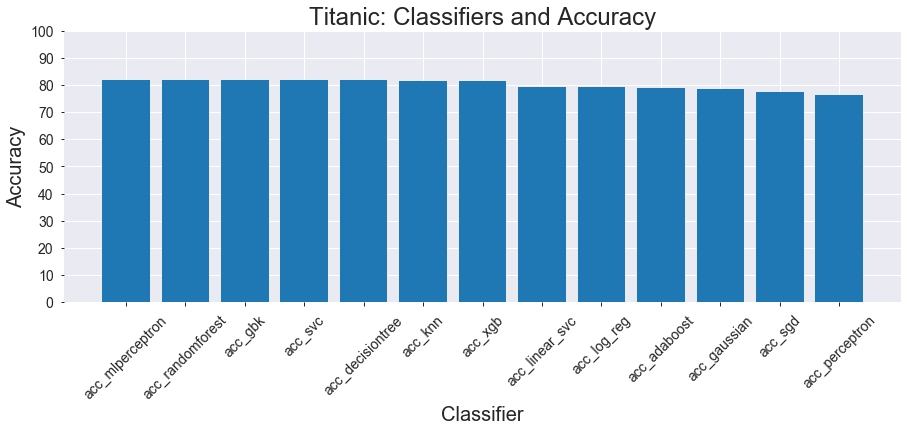

In [71]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
plt.bar("Classifier", "Accuracy", data=acclist.sort_values(by=["Accuracy"], ascending=False))
plt.title("Titanic: Classifiers and Accuracy", size=24)
plt.xlabel("Classifier", size=20)
plt.ylabel("Accuracy", size=20)
plt.xticks(ticks=acclist["Classifier"], size=14, rotation=45)
plt.yticks(ticks=[i for i in range(0,110,10)], size=14)
plt

We can see that several classifiers score similar accuracies for our problem with the best one(s) classifying approximately 82% of the training data correctly. We should use the best performer from these classifiers to predict the survivors in our test dataset. However, since several of these classifiers randomly generate weights for their calculations, the accuracies can vary each time we run the syntax. Nonetheless, our highest accuracy always remains close to 82%.

For this iteration, the multi-layer perceptron classifier reached the highest accuracy. Therefore, we will use it to predict the outputs for our test dataset. We need call it again in order to be able to use it outside of our function previously defined function. Moreover, we need to adjust our test inputs so they match the train inputs, as our classifier will expect the same format:

In [72]:
train_inputs_third.head(5)

,Gender,Pclass,Embarked_S,age_group_infant
190,1,-0.352091,1,0
490,0,0.841916,1,0
441,0,0.841916,1,0
504,1,-1.546098,1,0
720,1,-0.352091,1,0


In [73]:
test_inputs = test[["Gender","Pclass","Embarked_S","age_group_infant"]]
test_inputs.head(5)

,Gender,Pclass,Embarked_S,age_group_infant
891,0,0.841916,0,0
892,1,0.841916,1,0
893,0,-0.352091,0,0
894,0,0.841916,1,0
895,1,0.841916,1,0


In [74]:
    from sklearn.neural_network import MLPClassifier
    
    activation = ('identity', 'logistic', 'tanh', 'relu')
    solver = ('lbfgs', 'sgd', 'adam')
    learning_rate = ('constant', 'invscaling', 'adaptive')
    grid = {'activation': activation, 'solver': solver, 'learning_rate': learning_rate}
    perceptron2 = MLPClassifier(random_state=7)
    grid = GridSearchCV(estimator=perceptron2, param_grid=grid, cv=kfold, scoring='accuracy', n_jobs=-1)
    grid.fit(train_inputs_third,train_targets.values.reshape(-1,1))
    perceptron2 = grid.best_estimator_

In [75]:
predictions_perceptron = pd.DataFrame(perceptron2.predict(test_inputs))

*This code exports the predictions from the perceptron classifier as a csv file, which we can submit to Kaggle to receive or accuracy score for the test outputs*

export_predictions = round(predictions_perceptron)
export_predictions.to_csv('pred_perceptron_export.csv')

The submitted file classified 78% percent of the survivors correctly.